<a href="https://colab.research.google.com/github/trcamnguyen/Logistic-Regression/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/username/repo-name/blob/main/notebook.ipynb)


# Logistic Regression for Text Classification

## Overview
This notebook implements and evaluates **Logistic Regression models** for text classification tasks:
- **Binary Logistic Regression**: Sentiment analysis (positive vs negative)
- **Multinomial Logistic Regression**: Multi-class text classification (softmax regression)

## Objectives
- Build Logistic Regression models for both binary and multi-class text data
- Understand differences between binary vs multinomial logistic regression
- Evaluate model quality with accuracy, precision, recall, F1-score, and confusion matrix



---

## Expected Outcomes
- **Binary Logistic Regression**: Effective sentiment classifier with clear positive/negative separation  
- **Multinomial Logistic Regression**: Generalized model for multi-class problems using softmax  
- **Evaluation Metrics**: Demonstrated on both binary and multi-class datasets  
- **Insights**: Comparison of logistic regression behavior in binary vs multinomial settings  

---


In [82]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import random
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.special import softmax as sftmx
random.seed(123)
np.random.seed(123)

# Part I. Binary Logistic Regression (Sentiment Analysis)

### Step 1. **Data Loading**
- **Dataset**: Import sentiment dataset (e.g., Sentiment140 or custom text dataset)
- **File Access**: Load text samples and corresponding binary sentiment labels
- **Initial Inspection**: Preview data distribution (positive vs negative)

---

### Step 2. **Data Preprocessing**
- **Text Cleaning**: Remove punctuation, digits, and special characters  
- **Normalization**: Convert to lowercase  
- **Tokenization**: Split text into words or tokens  
- **Stopword Removal** *(optional)*  

---

### Step 3. **Feature Representation**
- **Bag-of-Words**: Convert tokenized text into numerical feature vectors  
- **Vocabulary Construction**: Build word-index mapping  
- **Binary/Count Representation**: Represent presence or frequency of terms  

---

### Step 4. **Model Construction**
- **Hypothesis Function**:  
  $$ h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}} $$
- **Loss Function (Binary Cross-Entropy)**:  
  $$ J(\theta) = -\frac{1}{m}\sum_{i=1}^m \Big[y^{(i)}\log h_\theta(x^{(i)}) + (1-y^{(i)})\log(1-h_\theta(x^{(i)}))\Big] $$
- **Training**: Fit logistic regression classifier on binary labels  

---

### Step 5. **Evaluation**
- **Metrics**: Accuracy, Precision, Recall, F1-score  
- **Confusion Matrix**: Visualize predictions vs ground truth  
- **Error Analysis**: Inspect misclassified examples

In [3]:
import kagglehub
# Download Sentiment140
path = kagglehub.dataset_download("kazanova/sentiment140")
file_path = path + "/training.1600000.processed.noemoticon.csv"

cols = ['target','id','date','flag','user','text']
df = pd.read_csv(file_path, encoding='ISO-8859-1', names=cols)

df = df[['text','target']]
df['target'] = df['target'].replace(4,1)

df_small = df.sample(n=10000, random_state=42)

# Split train/dev/test
train_df, test_df = train_test_split(df_small, test_size=0.2, random_state=42, stratify=df_small['target'])
train_df, dev_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['target'])

data_tr_textlist = train_df[['text']].values.tolist()
ArrayTR = train_df[['target']].to_numpy()

data_dev_textlist = dev_df[['text']].values.tolist()
ArrayDev = dev_df[['target']].to_numpy()

data_test_textlist = test_df[['text']].values.tolist()
ArrayTest = test_df[['target']].to_numpy()

print("Binary dataset size:", len(df_small))
print("Train/Dev/Test:", len(data_tr_textlist), len(data_dev_textlist), len(data_test_textlist))


Using Colab cache for faster access to the 'sentiment140' dataset.
Binary dataset size: 10000
Train/Dev/Test: 7200 800 2000


In [4]:
stop_words = ['a','in','on','at','and','or',
              'to', 'the', 'of', 'an', 'by',
              'as', 'is', 'was', 'were', 'been', 'be',
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
             'his', 'her', 'they', 'them', 'from', 'with', 'its','also','so','there','their','The']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [5]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words= stop_words, vocab=set()):


    ####Tokenisation#######
    com = re.compile(token_pattern)
    x_raw = com.findall(x_raw)
    # vocab = re.findall(token_pattern,vocab)

   # x_raw = list(x_raw.split())     #Split Sentence into seperate words then store as list


 #####Remove Stop words########
    x_raw=[word for word in x_raw if word not in stop_words]
    for word in stop_words:
        for word2 in x_raw:
            if word == word2:
                x_raw.remove(word)



    #print(vocab)

#######Return Vocab#####
    #vocab needs to normalised
    vocab1 = str(vocab)
    vocab1 = re.findall(token_pattern,vocab1)
    commachar = ","
    spacechar = ''
    if ((len(vocab1)) != 0): #Check if set is empty
        vocablist = []
        for word in x_raw:
            for word2 in vocab1:
                if ((word == word2) & (word != commachar) & (word != spacechar)& (word2 not in vocablist)): #remove commas & match words in text &vocab
                    vocablist.append(word.replace(" ", "")) ## remove whitespace characters
                   # print(vocablist)

    noofngrams=[]
    ngrams_list = []
    if ngram_range == (1,3):
        noofngrams= [1,2,3]
    if ngram_range == (1,2):
        noofngrams= [1,2]

    y =[]

    #Extract Ngrams
    for n in noofngrams:
        if (len(vocab)) == 0:
                for num in range(0, len(x_raw)):
                    ngram = ' '.join(x_raw[num:num + n])
                    #if ngram not in ngrams_list:
                    if ((ngram != '')):
                        ngrams_list.append(ngram)
                        if ngram not in y:
                            y.append(ngram)

        if (len(vocab)) != 0:
                for n in range(0,len(vocab1)):
                    for num in range(0, len(vocablist)):
                        if len(vocablist[num]) != 0:
                                ngram = ' '.join(vocablist[num:num + n])

                                if ((ngram != '')): # ((ngram not in ngrams_list) &
                                    ngrams_list.append(ngram)

                                    if ngram not in y:
                                        y.append(ngram)

    x= ngrams_list
    return x,y # y is unique ngram list, x is list including duplicates for vectorisation

In [6]:
x1,y1 = extract_ngrams("this is a great movie to watch",
               ngram_range=(1,3),
               stop_words=stop_words)
print(y1)

['great', 'movie', 'watch', 'great movie', 'movie watch', 'great movie watch']


Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [7]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):

    #Define empty placeholder variables
    df=  Counter()
    ngram_counts = Counter()
    vocab = set()
    df1 = list()
    df2 = Counter()
    #com = re.compile(token_pattern)
    #X_raw = com.findall(X_raw)
    vocab1 = set()

    for x_raw in X_raw:
        x_raw = str(x_raw)
        com = re.compile(token_pattern)
        x_raw = com.findall(x_raw)
        x_raw = str(x_raw)
        x_raw.replace(" ", "")
        x_raw.replace("[","")
        x_raw.replace("]","")
        y,x = extract_ngrams(x_raw, ngram_range, token_pattern, stop_words)
        #calling extract_ngrams deals with tokenisation,stop words,ngram range and ngram extraction
        for item in x:
            df[item] += 1
            if df[item]> min_df: # Only keep above the minimum
                df2[item] += 1

            if (str(item) not in vocab) & (len(vocab) < keep_topN): #stop adding to vocab once cap is reached
            #vocab.add(str(x))
                 vocab.add(str(item)) #need to remove brackets as i think its passing

        for string in x:
            if string in ngram_counts:
                    ngram_counts[string] += 1 #len 998359
            else:
                    ngram_counts[string] = 1
    #df1.append(df2.most_common(keep_topN)) #Keep only the specified amount of N
    #ngram_counts.append(ngram_counts.most_common(keep_topN))
    #vocab = list(vocab)
    df = df2


#######assign top ngrams to vocab set###########################
   # vocab1 = set()
    for item in ngram_counts.most_common(keep_topN):

            # type(item)) item is a tupple
        if (len(vocab1) < keep_topN)  :
                vocab1.add(item[0])

    vocab = vocab1
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [8]:
vocab, df, ngram_counts = get_vocab(data_tr_textlist, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['conversation', 'gotta go', 'hadn', 'recovering', 'Sun', 'had dog', 'using', 'if like', 'learn how', 'visit', 'theme', 'Help', 'turned', 'admit', 'Cant wait', 'But no', 'my office', 'kinda sad', 'whole thing', 'posted', 'la', 'challenge', 'reason', 'every', 'just go', 'Busy', 'one me', 'survived', 'trust', 'battery', 'margaritas', 'Maybe next', 'feels', 'bringing', 'Much', 'tired my', 'Wow', 'flying', 'Liverpool', 'cousin', 'yet', 'platform', 'things', 'skin', 'daughter', 'homee', 'parents', 'Went', 'day using www', 'Men', 'asking', 'least', 'if re', 'Dinner', 'studies', 'tears', 'feet hurt', 'much', 'studio', 'vote', 'work now', 'cares', 'but still', 'not good', 'some reason', 'awhile', 'me some', 'good night sleep', 'invite', 'gift', 'drama', 'Cant', 'during', 'server', 'wanna', 'easily', 've always', 'nonsense', 'out here', 'MORE', 'all my followers', 'Coffee', 'Yeah', 'wanting', 'unfair', 'com my', 'see play', 'sound', 'burnt', 'smile my face', 'cd', 'me please', 'Aww man', 

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [9]:
list_of_vocab = list(vocab)
vocab_id = {i:list_of_vocab[i] for i in range(len(vocab))}

Now you should be able to extract n-grams for each text in the training, development and test sets:

## Vectorise documents

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text (doc) is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality N x |vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [10]:
#Take training set as input
#divide into doc
#extract each ngram for each doc
#Count ngram in doc using counter
#iterate counter through the vocab and assign counts in that order
def Extract_X_ngram(data_tr_textlist):
    X_ngram =[]
    for line in data_tr_textlist:
        ngram,p = list(extract_ngrams(str(line),stop_words= stop_words))
        X_ngram.append(ngram)
    return X_ngram

X_ngram = Extract_X_ngram(data_tr_textlist)
#print(Counter(X_ngram[0]))

In [11]:
def vectorise(X_ngram, vocab):
    N = len(X_ngram) #Get Dimensions #1400 x 5000 for training set
    SizeOfSet = len(vocab)
    X_vec = np.zeros((N,SizeOfSet))
    counter_vect = Counter()
    i = 0
    temp_loc =0

    for row in X_ngram:
        counter_vect = Counter(row)
        #print(counter_vect)
        for item in row:
            if item in vocab:
                temp_loc= list_of_vocab.index(item) #get vocab_id of word
                X_vec[i][temp_loc] = counter_vect[item] #assign count corresponding to vocabID
        i+=1
    return X_vec

#### Count vectors

In [12]:
X_tr_count = vectorise(X_ngram,vocab)
print(X_tr_count)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
X_tr_count.shape #(1400, 5000)
type(X_tr_count)

numpy.ndarray

In [14]:
X_tr_count[:2,:50]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

## Train and Evaluate Logistic Regression with Count vectors


In [15]:
##Calculate X_dev_count & X_test_count
XDev_ngram = Extract_X_ngram(data_dev_textlist)
X_dev_count = vectorise(XDev_ngram,vocab)

XTest_ngram = Extract_X_ngram(data_test_textlist)
X_test_count = vectorise(XTest_ngram,vocab)

In [56]:
clf = LogisticRegression(
    # max_iter=1000,
    # solver="lbfgs",
    # multi_class="auto"
)
clf.fit(X_tr_count, ArrayTR.ravel())  # train

LogisticRegression()

In [58]:
y_pred_train = clf.predict(X_tr_count)
y_pred_dev   = clf.predict(X_dev_count)
y_pred_test  = clf.predict(X_test_count)

# Training set
print("=== Training Set ===")
print("Accuracy :", accuracy_score(ArrayTR, y_pred_train))
print("Precision:", precision_score(ArrayTR, y_pred_train, average='macro'))
print("Recall   :", recall_score(ArrayTR, y_pred_train, average='macro'))
print("F1-Score :", f1_score(ArrayTR, y_pred_train, average='macro'))

# Dev set
print("\n=== Dev Set ===")
print("Accuracy :", accuracy_score(ArrayDev, y_pred_dev))
print("Precision:", precision_score(ArrayDev, y_pred_dev, average='macro'))
print("Recall   :", recall_score(ArrayDev, y_pred_dev, average='macro'))
print("F1-Score :", f1_score(ArrayDev, y_pred_dev, average='macro'))
print("Confusion Matrix (Dev set):")
print(confusion_matrix(ArrayDev, y_pred_dev))

# Test set
print("\n=== Test Set ===")
print("Accuracy :", accuracy_score(ArrayTest, y_pred_test))
print("Precision:", precision_score(ArrayTest, y_pred_test, average='macro'))
print("Recall   :", recall_score(ArrayTest, y_pred_test, average='macro'))
print("F1-Score :", f1_score(ArrayTest, y_pred_test, average='macro'))
print("Confusion Matrix (Test set):")
print(confusion_matrix(ArrayTest, y_pred_test))

=== Training Set ===
Accuracy : 0.9113888888888889
Precision: 0.9116393671581806
Recall   : 0.9113992440272528
F1-Score : 0.9113768262902451

=== Dev Set ===
Accuracy : 0.7125
Precision: 0.712760631773923
Recall   : 0.7124999999999999
F1-Score : 0.7124119261523842
Confusion Matrix (Dev set):
[[278 122]
 [108 292]]

=== Test Set ===
Accuracy : 0.7115
Precision: 0.711577551126565
Recall   : 0.7115092115092114
F1-Score : 0.7114791543689032
Confusion Matrix (Test set):
[[703 298]
 [279 720]]


/tmp/ipython-input-459666635.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=metrics, palette="viridis")


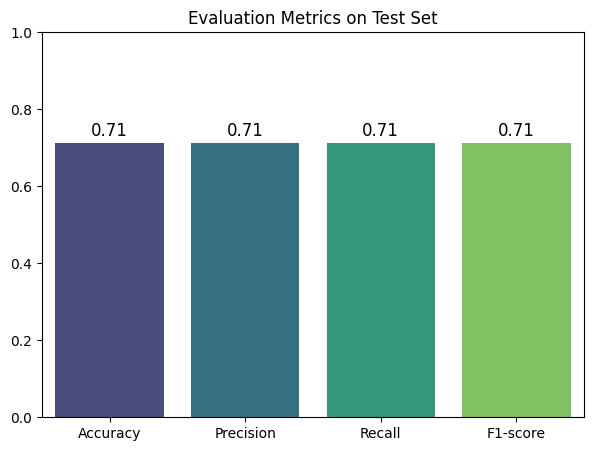

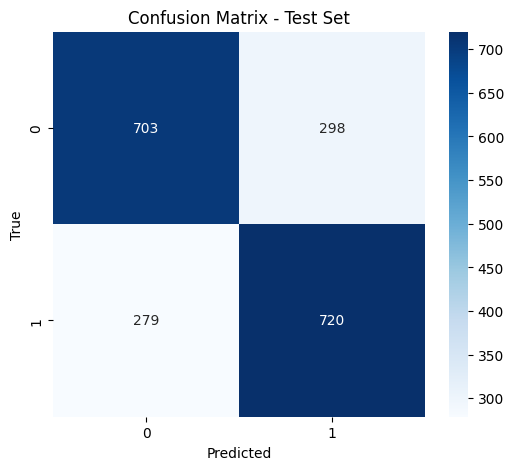

In [87]:
# Test set
acc  = accuracy_score(ArrayTest, y_pred_test)
prec = precision_score(ArrayTest, y_pred_test, average='macro')
rec  = recall_score(ArrayTest, y_pred_test, average='macro')
f1   = f1_score(ArrayTest, y_pred_test, average='macro')


metrics = [acc, prec, rec, f1]
names = ["Accuracy", "Precision", "Recall", "F1-score"]

# Plot metrics bar chart
plt.figure(figsize=(7,5))
sns.barplot(x=names, y=metrics, palette="viridis")
plt.ylim(0,1)
plt.title("Evaluation Metrics on Test Set")
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.show()

# Plot confusion matrix heatmap ===
cm = confusion_matrix(ArrayTest, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [81]:
# 1. New input sentence
new_sentence = ["Best tweet ever!"]

# 2. Convert the new sentence into n-grams (same as during training)
new_sentence_ngram = Extract_X_ngram(new_sentence)

# 3. Vectorize using the custom function
X_new = vectorise(new_sentence_ngram, list_of_vocab)

# 4. Predict the label
y_pred_new = clf.predict(X_new)

print("Predicted label for the sentence:", new_sentence[0])
print("Result:", y_pred_new[0])


Predicted label for the sentence: Best tweet ever!
Result: 1


# Part II. Multinomial Logistic Regression (Multi-class Classification)

### Step 1. **Data Loading**
- **Dataset**: Import a multi-class dataset (e.g., 20 Newsgroups, or custom dataset with >2 categories)  
- **File Access**: Load documents with category labels  
- **Initial Inspection**: Show sample text and class distribution  

---

### Step 2. **Data Preprocessing**
- **Text Cleaning**: Lowercasing, punctuation removal  
- **Tokenization**: Segment into words  
- **Stopword Removal** *(optional)*  

---

### Step 3. **Feature Representation**
- **Bag-of-Words / Count Vectors**: Convert tokens into numerical features  
- **Vocabulary**: Build based on training data  
- **Matrix Representation**: Documents → rows, words → columns  

---

### Step 4. **Model Construction**
- **Softmax Function**:  
  $$ P(y=k|x) = \frac{e^{\theta_k^T x}}{\sum_{j=1}^K e^{\theta_j^T x}} $$
- **Loss Function (Multiclass Cross-Entropy)**:  
  $$ J(\theta) = -\frac{1}{m}\sum_{i=1}^m \sum_{k=1}^K \mathbf{1}\{y^{(i)}=k\}\log P(y=k|x^{(i)}) $$
- **Training**: Fit multinomial logistic regression with gradient descent  

---

### Step 5. **Evaluation**
- **Metrics**: Accuracy, Precision, Recall, F1-score (per class & macro/weighted)  
- **Confusion Matrix**: Show classification distribution across classes  
- **Error Analysis**: Inspect common misclassifications  

---

## Required Libraries
- **`pandas`, `numpy`**: Data handling  
- **`scikit-learn`**: Logistic regression, model evaluation  
- **`matplotlib`, `seaborn`**: Visualization  
- **`collections`**: Frequency counts  


In [118]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

categories = ['sci.med','rec.sport.hockey', 'sci.space', 'talk.religion.misc', 'comp.graphics']

newsgroups_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    remove=('headers','footers','quotes')
)
newsgroups_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    remove=('headers','footers','quotes')
)

# Combine train + test to select a subset of ~3000
all_texts = newsgroups_train.data + newsgroups_test.data
all_labels = list(newsgroups_train.target) + list(newsgroups_test.target)

# Randomly sample 3000 (here: 4000)
subset_texts, _, subset_labels, _ = train_test_split(
    all_texts,
    all_labels,
    train_size=4000,
    stratify=all_labels,
    random_state=42
)

# Split into train/dev/test (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(
    subset_texts, subset_labels,
    test_size=0.3, random_state=42, stratify=subset_labels
)
X_dev, X_test, y_dev, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, random_state=42, stratify=y_temp
)

Topic_data_tr = pd.DataFrame({"label": y_train, "text": X_train})
Topic_data_dev = pd.DataFrame({"label": y_dev, "text": X_dev})
Topic_data_test = pd.DataFrame({"label": y_test, "text": X_test})

# Create list + numpy array (old format)
topic_tr_textlist = Topic_data_tr[["text"]].values.tolist()
ArrayTR_Topic = Topic_data_tr[["label"]].to_numpy()

topic_dev_textlist = Topic_data_dev[["text"]].values.tolist()
ArrayDev_Topic = Topic_data_dev[["label"]].to_numpy()

topic_test_textlist = Topic_data_test[["text"]].values.tolist()
ArrayTest_Topic = Topic_data_test[["label"]].to_numpy()

print("Train size:", len(Topic_data_tr))
print("Dev size:", len(Topic_data_dev))
print("Test size:", len(Topic_data_test))
print("Number of classes:", len(np.unique(ArrayTR_Topic)))

Topic_data_tr.head()


Train size: 2800
Dev size: 600
Test size: 600
Number of classes: 5


,label,text
0,3,At one time there was speculation that the fir...
1,0,I am looking for some fast polygon routines (S...
2,1,Can some on e give me some stats on Forsrg in ...
3,3,Regarding the feasability of retrieving the HS...
4,1,-=> Quoting Greg Rogers to All <=-\n GR> Hi al...


In [119]:
print(len(topic_test_textlist))

600


In [120]:
Topic_data_tr.head()

,label,text
0,3,At one time there was speculation that the fir...
1,0,I am looking for some fast polygon routines (S...
2,1,Can some on e give me some stats on Forsrg in ...
3,3,Regarding the feasability of retrieving the HS...
4,1,-=> Quoting Greg Rogers to All <=-\n GR> Hi al...


In [121]:
topic_vocab, topic_df, topic_ngram_counts_tr = get_vocab(topic_tr_textlist, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
#topic_vocab, topic_df_dev, topic_ngram_counts_dev = get_vocab(topic_dev_textlist, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
#topic_vocab,topic_df_test,topic_ngram_counts_test = get_vocab(topic_test_textlist, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

In [122]:
list_of_vocab = list(topic_vocab)
vocab_id_topic = {i:list_of_vocab[i] for i in range(len(topic_vocab))}

In [123]:
print(len(topic_vocab))
print(list(topic_vocab)[:100])
print()
print(topic_df.most_common()[:10])
#print(list_of_vocab[:10])

5000
['shareware', 'Sun', 'Colorado', 'depth', 'nanother', 'permanent', 'using', 'Habs', 'In fact', 'visit', 'all sorts', 'Stanford', 'chronic', 'turned', 'admit', 'fitting', 'nproblem', 'posted', 'reason', 'every', 'bother', 'Description', 'assist', 'Guide', 'Engineering', 'solar', 'Macintosh', 'Hall', 'themselves', 'owned', 'aware', 'bringing', 'It would', 'Goal', 'Much', 'ndon', 'rights', 'burden', 'bacteria', 'referring', 'nMark', 'flying', 'manned', 'large', 'yet', 'platform', 'Otto', 'explains', 'berkeley', 'things', 'scale', 'skin', 'raw', 'daughter', 'wisc', 'exposure', 'parents', 'News', 'asking', 'least', 'if re', 'magnetic', 'studies', 'puts', 'much', 'arguments', 'vote', 'second period', 'cares', 'but still', 'not good', 'Pluto', 'preventing', 'comp', 'me some', 'binary', 'Sharks', 'during', 'server', 'rendering', 'easily', 'nonsense', 'automatically', 'Dryden', 'condition', 'ngeb cadre', 'cadre', 'Matthew', 'terminal', 'designed', 'detail', 'same way', 'if don', 'mit edu',

In [124]:
topic_X_tr_ngram = Extract_X_ngram(topic_tr_textlist)
topic_X_tr_count = vectorise(topic_X_tr_ngram,topic_vocab)

topic_XDev_ngram = Extract_X_ngram(topic_dev_textlist)
topic_X_dev_count = vectorise(topic_XDev_ngram,topic_vocab)

topic_XTest_ngram = Extract_X_ngram(topic_test_textlist)
topic_X_test_count = vectorise(topic_XTest_ngram,topic_vocab)

In [125]:
def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z)

def predict_proba_multi(x, W):
    scores = np.dot(W, x)  # (num_classes,)
    return softmax(scores)

def categorical_loss(X, y, W, num_classes, alpha=0.0):
    N = X.shape[0]
    loss = 0.0
    for i in range(N):
        probs = predict_proba_multi(X[i], W)
        loss += -np.log(probs[int(y[i])])
    loss /= N
    loss += alpha * np.sum(W * W)  # regularization
    return loss

def SGDMulti(X_tr, Y_tr, X_dev=None, Y_dev=None, num_classes=5,
             lr=0.001, alpha=0.0001, epochs=5, tolerance=1e-5,
             print_progress=True):

    training_loss_history = []
    validation_loss_history = []

    # W: (num_classes, d)
    W = np.zeros((num_classes, X_tr.shape[1]))
    N = len(Y_tr)

    for ep in range(epochs):
        np.random.seed(ep + 3)
        shuffle_idx = np.random.permutation(N)
        X_tr, Y_tr = X_tr[shuffle_idx], Y_tr[shuffle_idx]

        for i in range(N):
            x = X_tr[i]
            y = int(Y_tr[i])
            probs = predict_proba_multi(x, W)

            for c in range(num_classes):
                y_c = 1 if c == y else 0
                grad = (probs[c] - y_c) * x + 2 * alpha * W[c]
                W[c] -= lr * grad

        loss_train = categorical_loss(X_tr, Y_tr, W, num_classes, alpha)
        loss_dev = None
        if X_dev is not None and Y_dev is not None:
            loss_dev = categorical_loss(X_dev, Y_dev, W, num_classes, alpha)

        training_loss_history.append(loss_train)
        validation_loss_history.append(loss_dev)

        if print_progress:
            print(f"Epoch {ep+1}: Train Loss={loss_train:.4f} | Dev Loss={loss_dev:.4f}")

        if ep > 0 and loss_dev is not None:
            if abs(validation_loss_history[-2] - validation_loss_history[-1]) < tolerance:
                print("Tolerance reached -> Early stopping")
                break

    return W, training_loss_history, validation_loss_history, ep+1

def predict_multi(X, W):
    if W.shape[0] != X.shape[1]:
        W = W.T

    scores = np.dot(X, W)  # (n_samples, n_classes)
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [126]:
topic_w_count, topic_loss_tr_count, topic_dev_loss_count,epochmax3 = SGDMulti(X_tr =topic_X_tr_count, Y_tr = ArrayTR_Topic,
                                             X_dev=topic_X_dev_count,
                                             Y_dev=ArrayDev_Topic,
                                             num_classes=5,
                                             lr=0.001,
                                             alpha=0.001,
                                             epochs=4)

/tmp/ipython-input-2963460902.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(Y_tr[i])
/tmp/ipython-input-2963460902.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss += -np.log(probs[int(y[i])])


Epoch 1: Train Loss=1.1549 | Dev Loss=1.1908
Epoch 2: Train Loss=0.9968 | Dev Loss=1.0482
Epoch 3: Train Loss=0.9039 | Dev Loss=0.9660
Epoch 4: Train Loss=0.8401 | Dev Loss=0.9104


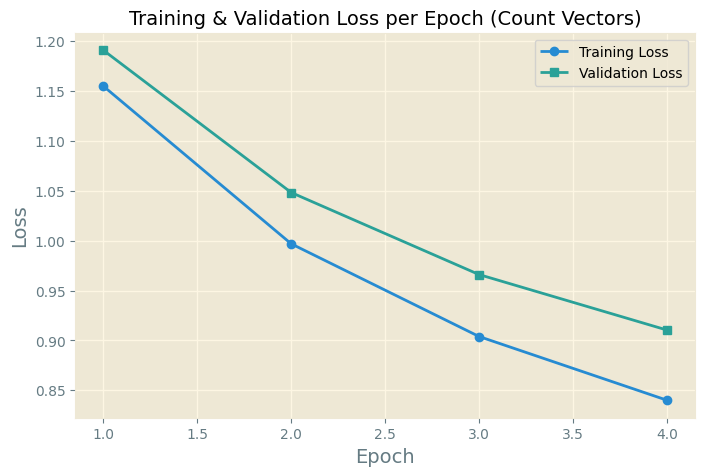

In [127]:
epochs_arr = np.arange(1, epochmax3 + 1)

plt.figure(figsize=(8,5))
with plt.style.context('Solarize_Light2'):
    plt.plot(epochs_arr, topic_loss_tr_count, marker='o', label="Training Loss")
    plt.plot(epochs_arr, topic_dev_loss_count, marker='s', label="Validation Loss")
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training & Validation Loss per Epoch (Count Vectors)', fontsize=14)
    plt.legend()
    plt.grid(True)
plt.show()

In [128]:
y_pred_train = predict_multi(topic_X_tr_count, topic_w_count)
y_pred_dev   = predict_multi(topic_X_dev_count, topic_w_count)
y_pred_test  = predict_multi(topic_X_test_count, topic_w_count)

# ======================
# Training set
# ======================
print("=== Training Set ===")
print("Accuracy :", accuracy_score(ArrayTR_Topic, y_pred_train))
print("Precision:", precision_score(ArrayTR_Topic, y_pred_train, average='macro'))
print("Recall   :", recall_score(ArrayTR_Topic, y_pred_train, average='macro'))
print("F1-Score :", f1_score(ArrayTR_Topic, y_pred_train, average='macro'))

# ======================
# Dev set
# ======================
print("\n=== Dev Set ===")
print("Accuracy :", accuracy_score(ArrayDev_Topic, y_pred_dev))
print("Precision:", precision_score(ArrayDev_Topic, y_pred_dev, average='macro'))
print("Recall   :", recall_score(ArrayDev_Topic, y_pred_dev, average='macro'))
print("F1-Score :", f1_score(ArrayDev_Topic, y_pred_dev, average='macro'))

print("Confusion Matrix (Dev set):")
print(confusion_matrix(ArrayDev_Topic, y_pred_dev))

# ======================
# Test set
# ======================
print("\n=== Test Set ===")
print("Accuracy :", accuracy_score(ArrayTest_Topic, y_pred_test))
print("Precision:", precision_score(ArrayTest_Topic, y_pred_test, average='macro'))
print("Recall   :", recall_score(ArrayTest_Topic, y_pred_test, average='macro'))
print("F1-Score :", f1_score(ArrayTest_Topic, y_pred_test, average='macro'))

print("Confusion Matrix (Test set):")
print(confusion_matrix(ArrayTest_Topic, y_pred_test))


=== Training Set ===
Accuracy : 0.8453571428571428
Precision: 0.8539419576742141
Recall   : 0.8377146981472855
F1-Score : 0.8425159424843546

=== Dev Set ===
Accuracy : 0.7883333333333333
Precision: 0.8005119445717593
Recall   : 0.7794932805598181
F1-Score : 0.785477654942866
Confusion Matrix (Dev set):
[[110   0   9   8   0]
 [  8 109   6   5   3]
 [ 20   1 101   4   4]
 [ 14   3  11  98   3]
 [  4   5  10   9  55]]

=== Test Set ===
Accuracy : 0.7866666666666666
Precision: 0.7845590564174703
Recall   : 0.771997786491857
F1-Score : 0.7750565389776789
Confusion Matrix (Test set):
[[111   3   7   6   1]
 [  3 111   6   2   9]
 [ 12   3 105   6   3]
 [ 15   2  12  97   4]
 [  7   6  11  10  48]]


/tmp/ipython-input-1160849350.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=metrics, palette="viridis")


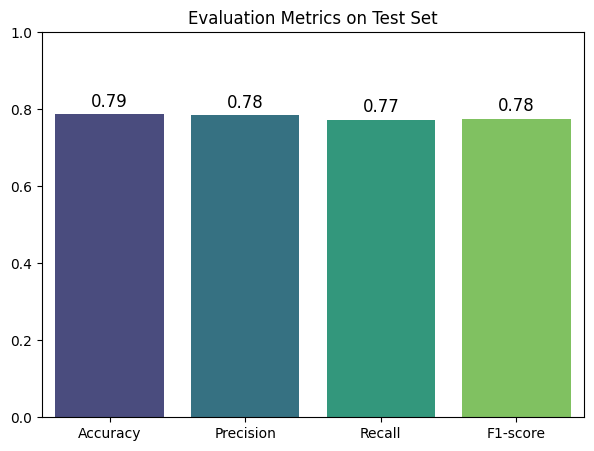

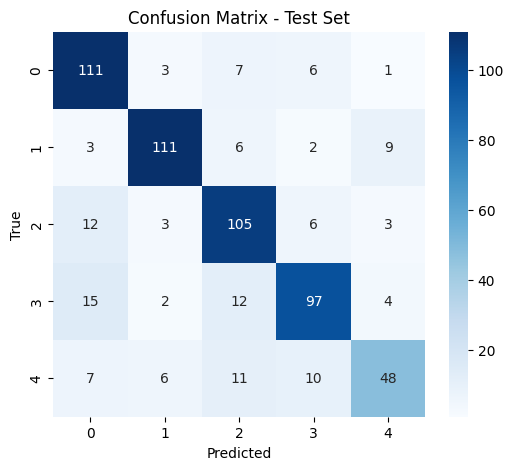

In [135]:
# --- Test set metrics bar chart ---
acc  = accuracy_score(ArrayTest_Topic, y_pred_test)
prec = precision_score(ArrayTest_Topic, y_pred_test, average='macro')
rec  = recall_score(ArrayTest_Topic, y_pred_test, average='macro')
f1   = f1_score(ArrayTest_Topic, y_pred_test, average='macro')

metrics = [acc, prec, rec, f1]
names = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(7,5))
sns.barplot(x=names, y=metrics, palette="viridis")
plt.ylim(0,1)
plt.title("Evaluation Metrics on Test Set")
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.show()

# --- Confusion Matrix (Test set) heatmap ---
cm_test = confusion_matrix(ArrayTest_Topic, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [138]:
# 1. New input
new_sentence = ["NASA announced a new mission to send astronauts to Mars by 2035."]

# 2. Convert sentence to n-gram
new_sentence_ngram = Extract_X_ngram(new_sentence)

# 3. Vectorize
X_new_count = vectorise(new_sentence_ngram, list_of_vocab)

# 4. Predict numeric label
y_pred = predict_multi(X_new_count, topic_w_count)

# 5. Map numeric label to class name
categories = ['sci.med', 'rec.sport.hockey', 'sci.space', 'talk.religion.misc', 'comp.graphics']
newsgroups_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    remove=('headers','footers','quotes')
)

# mapping số → tên class
label_to_class = {i: name for i, name in enumerate(newsgroups_train.target_names)}

print("Sentence:", new_sentence[0])
print("Predicted label (number):", y_pred[0])
print("Predicted class name    :", label_to_class[y_pred[0]])


Sentence: NASA announced a new mission to send astronauts to Mars by 2035.
Predicted label (number): 3
Predicted class name    : sci.space
